# Scenario 1: VGG19 with Keyframe Extraction

## Functions

In [153]:
# Import Required Libraries

# General Libraries
import os
import cv2
import time
import shutil
import itertools
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

# Katna Libraries
from Katna.video import Video
from Katna.writer import KeyFrameDiskWriter

# Data Preprocessing Libraries
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Adam Optimizer Libraries
from keras.optimizers.legacy import Adam # for Apple Silicon
# from keras.optimizers import Adam # for Windows

# VGG19 Libraries
from keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Flatten, BatchNormalization, Dropout

# Evaluation Libraries
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [154]:
# Data Information Function
def data_information(dataframe, file_output_path, filename):
    file_type = dataframe.columns[1].split()[0]

    # Check if folder exists
    if not os.path.exists(file_output_path):
        os.makedirs(file_output_path)

    # Writing the data information to a text file
    with open(os.path.join(file_output_path, f"data_information_{filename}.txt"), 'w') as f:
        f.write("*"*50)
        f.write("\n")
        f.write("*"*50)
        f.write("\n")
        f.write("DATA INFORMATION".center(50))
        f.write("\n")
        f.write("*"*50)
        f.write("\n")
        f.write(f"Number of Labels : {dataframe['Label Type'].nunique()} Labels")
        f.write("\n")
        f.write(f"Number of {file_type}s : {len(dataframe)} {file_type}s")
        f.write("\n")
        f.write("*"*50)
        f.write("\n")
        for i in dataframe['Label Type'].value_counts().index:
            f.write(f"{i.ljust(20)} : {dataframe['Label Type'].value_counts()[i]} {file_type}s")
            f.write("\n")
        f.write("*"*50)
        f.write("\n")
        f.write("*"*50)
    
    # save dataframe to csv
    dataframe.to_csv(os.path.join(file_output_path, f"dataframe_{filename}.csv"), index=False)
    
    # showing the data information
    with open(os.path.join(file_output_path, f"data_information_{filename}.txt"), 'r') as f:
        print(f.read())

In [155]:
# Data Initialization Function
def data_initialization(dataset_path, file_output_path):
    # get the list of all the label types
    label_type = [item for item in os.listdir(dataset_path) if not item.startswith('.')]
    
    # get the list of all the videos
    activities = []
    for label in label_type:
        all_items = os.listdir(os.path.join(dataset_path, label))
        for item in all_items:
            if item.startswith('.'):
                continue
            else:
                videos = os.listdir(os.path.join(dataset_path, label, item))
            for video in videos:
                if video.endswith('.mp4'):      # can be changed to any other video format
                    activities.append((label, os.path.join(dataset_path, label, item, video)))
    
    # create a dataframe
    df = pd.DataFrame(activities, columns=['Label Type', 'Video Path'])

    # print data information
    data_information(dataframe=df, file_output_path=file_output_path, filename="data_initialization")

    return df

In [156]:
# Keyframe Extraction Function
def keyframe_extraction(dataframe, extracted_keyframes_output_folder, no_of_frames_to_returned):
  # start time
  start_time = time.time()

  # print initial message
  print(f"Extracting Keyframes from {len(dataframe)} videos...")
  
  # create a directory to save the keyframes
  os.makedirs(extracted_keyframes_output_folder, exist_ok=True)

  # For windows, the below if condition is must.
  if __name__ == "__main__":
    # initialize video module
    vd = Video()

    # number of images to be returned
    no_of_frames_to_returned = no_of_frames_to_returned # can be changed as per requirement

  # Extracting keyframe from all videos
  for i in tqdm(range(len(dataframe)), desc="Extracting Keyframes from Videos", colour='green'):
    # initialize diskwriter to save data at desired location
    diskwriter = KeyFrameDiskWriter(location=extracted_keyframes_output_folder + "/" + dataframe.iloc[i]['Label Type'])

    # Video file path
    video_file_path = dataframe.iloc[i]['Video Path']

    # extract keyframes and process data with diskwriter
    vd.extract_video_keyframes(
      no_of_frames=no_of_frames_to_returned, 
      file_path=video_file_path,
      writer=diskwriter
    )

  # end time
  end_time = time.time()
 
  # round the execution time to 2 decimal places
  exec_time = end_time - start_time
  exec_time = round(exec_time, 2)

  # print final message
  print("Keyframes extracted successfully!")
  print(f"Keyframes extracted from {len(dataframe)} videos and saved in {extracted_keyframes_output_folder}")
  print(f"Time taken to extract keyframes from {len(dataframe)} videos : {exec_time} seconds")

  return exec_time

In [157]:
# Data Initialization for Split Function
def data_initialization_split(dataset_path, file_output_path):
    # get the list of all the label types
    label_type = [item for item in os.listdir(dataset_path) if not item.startswith('.')]
    
    # get the list of all the videos
    activities = []
    for label in label_type:
        if label.startswith('.'):
            continue
        videos = os.listdir(os.path.join(dataset_path, label))
        for video in videos:
            if video.endswith('.jpeg'):     # can add or change the image format
                activities.append((label, os.path.join(dataset_path, label, video)))
    
    # create a dataframe
    df_extract = pd.DataFrame(activities, columns=['Label Type', 'Image Path'])

    data_information(dataframe=df_extract, file_output_path=file_output_path, filename="data_initialization_split")
    
    return df_extract

In [158]:
# Copy Files Function
def copy_files(train_dataframe, test_dataframe):
    # load variables
    dataframes = [train_dataframe, test_dataframe]
    destination_folder = 'SplittedFrames/extractedKeyframes' # change the destination folder according to the need

    for dataframe in dataframes:
        # set the destination folder
        if dataframe is train_dataframe:
            destination = os.path.join(destination_folder, 'train')
            current_dataframe = "Train"
        else:
            destination = os.path.join(destination_folder, 'test')
            current_dataframe = "Test"
        
        # Iterate over each row in the dataframe and copy the file to the destination folder
        for index, row in tqdm(
            dataframe.iterrows(), 
            total=len(dataframe), 
            desc=f"Copying splitted {current_dataframe} files          ", 
            unit="files", 
            position=0, 
            leave=True, 
            colour="green"):
            # Get the source and destination paths
            source_path = row['Image Path']
            destination_subfolder = row['Label Type']
            destination_path = os.path.join(destination, destination_subfolder, os.path.basename(source_path))

            # Create the destination subfolder if it doesn't exist
            os.makedirs(os.path.join(destination, destination_subfolder), exist_ok=True)

            # Copy the file to the destination folder
            shutil.copyfile(source_path, destination_path)

In [159]:
# Copy Files Function with Grayscaling
def copy_files_grayscaled(train_dataframe, test_dataframe):
    # load variables
    dataframes = [train_dataframe, test_dataframe]
    destination_folder = 'SplittedFrames/extractedKeyframes_grayscaled' # change the destination folder according to the need

    for dataframe in dataframes:
        # set the destination folder
        if dataframe is train_dataframe:
            destination = os.path.join(destination_folder, 'train')
            current_dataframe = "Train"
        else:
            destination = os.path.join(destination_folder, 'test')
            current_dataframe = "Test"
        
        # Iterate over each row in the dataframe and copy the file to the destination folder
        for index, row in tqdm(
            dataframe.iterrows(), 
            total=len(dataframe), 
            desc=f"Copying splitted grayscale {current_dataframe} files ", 
            unit="files", 
            position=0, 
            leave=True, 
            colour="green"):
            # Get the source and destination paths
            source_path = row['Image Path']
            destination_subfolder = row['Label Type']
            destination_path = os.path.join(destination, destination_subfolder, os.path.basename(source_path))

            # Create the destination subfolder if it doesn't exist
            os.makedirs(os.path.join(destination, destination_subfolder), exist_ok=True)

            # Read the image
            image = cv2.imread(source_path)

            # Convert the image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Save the grayscale image to the destination folder
            cv2.imwrite(destination_path, gray_image)

should train and test set grayscaled images?

In [177]:
# Split Data Function
def split_data(dataframe, test_size, file_output_path):
    # print initial message
    print("Splitting the data into train and test...")

    # Split the data into train and test
    df_train, df_test = train_test_split(dataframe, test_size=test_size, random_state=42)

    # save the dataframes to csv
    df_train.to_csv(os.path.join(file_output_path, "dataframe_dataset_train.csv"), index=False)
    df_test.to_csv(os.path.join(file_output_path, "dataframe_dataset_test.csv"), index=False)

    # # copy files to the destination folder
    # copy_files(train_dataframe=df_train, test_dataframe=df_test)
    # copy_files_grayscaled(train_dataframe=df_train, test_dataframe=df_test)

    # print final message
    print("Data split successfully into train and test!")

    # print data information
    print("\n")
    print(f"Total image in train set    : {len(df_train)} images")
    print(f"Total image in test set     : {len(df_test)} images")

    return df_train, df_test

In [161]:
# Data Augmentation Function
def data_augmentation(img_width, img_height, batch_size):
    # Splitted data directories
    train_dir = 'SplittedFrames/extractedKeyframes_grayscaled/train'
    test_dir = 'SplittedFrames/extractedKeyframes_grayscaled/test'

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.2,
        horizontal_flip=True
    )

    # Data normalization for testing
    test_datagen = ImageDataGenerator(
        # rescale=1.0/255,
        # shear_range=0.2,
        # zoom_range=0.2,
        # horizontal_flip=True
    )

    # Load training data
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training', 
        shuffle=True
    )

    # Load validation data
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation', 
        shuffle=False
    )

    # Load testing data
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator


In [162]:
# VGG19 Model
def vgg19_model(learning_rate, train_generator, file_output_path):
    # Variable
    num_classes = train_generator.num_classes

    # Create the VGG19 model
    vgg_model = VGG19(pooling='max', weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers in the VGG19 model
    for layer in vgg_model.layers:
        layer.trainable = False

    # last layer
    last_layer = vgg_model.layers[-1].output

    # model definition
    model = Flatten()(last_layer)
    model = Dense(4096, activation='relu', name='fc1')(model)
    # model = BatchNormalization()(model)
    # model = Dropout(0.5)(model)
    model = Dense(4096, activation='relu', name='fc2')(model)
    # model = BatchNormalization()(model)
    # model = Dropout(0.5)(model)
    model = Dense(num_classes, activation='softmax')(model)
    final_model = Model(vgg_model.input, model, name='VGG19')

    # Compile the model
    final_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # callbacks
    folder_name = file_output_path
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    model_checkpoint_filename = 'Scenario1_checkpoint_epoch_{epoch:02d}_val_loss_{val_loss:.2f}_val_accuracy_{val_accuracy:.2f}_loss_{loss:.2f}_accuracy_{accuracy:.2f}.h5'
    model_checkpoint = ModelCheckpoint(os.path.join(folder_name, model_checkpoint_filename), monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    early_stopping = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
    
    return final_model, model_checkpoint, early_stopping

In [163]:
# Time Conversion Function
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
 
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [164]:
# Grid Search Print
def gs_print(accuracy, learning_rate, model, execution_time, file_output_path):
    # save cell output to a text file
    with open(os.path.join(file_output_path, "grid_search_output.txt"), "w") as f:
        print("*"*65, file=f)
        print("*"*65, file=f)
        print("GRID SEARCH RESULTS".center(65), file=f)
        print("*"*65, file=f)
        print(f"Best Learning Rate              : {learning_rate}", file=f)
        print(f"Best Accuracy                   : {accuracy}", file=f)
        print(f"Best Execution Time (seconds)   : {execution_time}", file=f)
        execution_time = convert(execution_time)
        print(f"Best Execution Time (hh:mm:ss)  : {execution_time}", file=f)
        print("*"*65, file=f)
        print("Summary of the Best Model".center(65), file=f)
        model.summary(print_fn=lambda x: f.write(x + '\n'))
        print("*"*65, file=f)
    
    with open(os.path.join(file_output_path, "grid_search_output.txt"), "r") as f:
        print(f.read())

In [165]:
# Grid Search Function
def grid_search(learning_rate, epochs, train_generator, val_generator, file_output_path):
    
    # all variables
    best_accuracy = 0
    best_val_accuracy = 0
    best_learning_rate = 0
    best_execution_time = 0
    best_model = None

    # Grid Search
    for lr in learning_rate:
        print(f"Learning Rate: {lr}")
        model, model_checkpoint, early_stopping = vgg19_model(learning_rate=lr, train_generator=train_generator, file_output_path=file_output_path)

        start_time = time.time()
        history = model.fit(train_generator, validation_data=val_generator, steps_per_epoch=len(train_generator), validation_steps=len(val_generator), epochs=epochs, callbacks=[model_checkpoint, early_stopping], verbose=1)
        end_time = time.time()
        exec_time = end_time - start_time
        exec_time = round(exec_time, 2)
        print(f"Time taken to train the {lr} model : {exec_time} seconds")

        # Save history to a file
        history_df = pd.DataFrame(history.history)
        history_df.to_csv(os.path.join(file_output_path, 'history.csv'), index=False)

        accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        if val_accuracy > best_val_accuracy:
            best_accuracy = accuracy
            best_val_accuracy = val_accuracy
            best_learning_rate = lr
            best_model = model
            best_execution_time = exec_time

    # Save the best_model
    best_model.save(os.path.join(file_output_path, 'best_model.h5'))
    
    return best_accuracy, best_learning_rate, best_model, best_execution_time

In [166]:
# Save the Model Plot Function
def save_plot_model(file_output_path):
    # history
    history = pd.read_csv(os.path.join(file_output_path, 'history.csv'))

    # plot the accuracy and loss of the model side by side
    plt.figure(figsize=(12, 6))

    # plot the accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # plot the loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # save the plot
    plt.savefig(os.path.join(file_output_path, 'model_accuracy_loss.png'))
    plt.show()

In [167]:
# Evaluate Model Function
def evaluate_model(test_generator, file_output_path):
    # load the best model
    model = load_model(os.path.join(file_output_path, 'best_model.h5'))

    # evaluate the model
    test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

    # save the evaluation results csv
    evaluation_results = pd.DataFrame({'Test Loss': [test_loss], 'Test Accuracy': [test_accuracy]})
    evaluation_results.to_csv(os.path.join(file_output_path, 'model_evaluation_results.csv'), index=False)

    # show the evaluation results csv
    print("\n")
    print("*"*75)
    print(tabulate(evaluation_results, headers='keys', tablefmt='pretty'))
    print(f"Model evaluation results saved in {file_output_path} as model_evaluation_results.csv")

In [168]:
# Predict Model Function
def predict_model(test_generator, file_output_path):
    """
    Predicts the classes for the given test data using a trained model and saves the predictions, evaluation results,
    confusion matrix, and classification report to CSV files.

    Args:
        test_generator (object): The test data generator.
        file_output_path (str): The path to save the output files.

    Returns:
        None
    """
    # model predictions
    # load the model
    model = load_model(os.path.join(file_output_path, 'best_model.h5'))

    # predict the model
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

    # get the class with the highest probability
    predicted_classes = np.argmax(predictions, axis=1)

    # get the actual class
    actual_classes = test_generator.classes

    # get the class labels
    class_labels = list(test_generator.class_indices.keys())


    
    # model predictions evaluation
    # confusion matrix
    cm = confusion_matrix(actual_classes, predicted_classes)

    # classification report
    cr = classification_report(actual_classes, predicted_classes, target_names=class_labels)
    
    # accuracy
    accuracy = accuracy_score(actual_classes, predicted_classes)

    # precision
    precision = precision_score(actual_classes, predicted_classes, average='weighted')

    # recall
    recall = recall_score(actual_classes, predicted_classes, average='weighted')

    # f1-score
    f1 = f1_score(actual_classes, predicted_classes, average='weighted')


    
    # print the confusion matrix and classification report
    print("\n")
    print("*"*75)
    print("Confusion Matrix".center(75))
    print(cm)
    print("*"*75)
    print("Classification Report".center(75))
    print(cr)
    print("*"*75)
    
    # plot confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(os.path.join(file_output_path, 'confusion_matrix.png'))

    
    # save the evaluation results
    print("\n")
    print("*"*75) 
    # save the model predictions to a csv
    predictions_df = pd.DataFrame(predictions, columns=class_labels)
    predictions_df['Actual Class'] = actual_classes
    predictions_df['Predicted Class'] = predicted_classes
    predictions_df.to_csv(os.path.join(file_output_path, 'model_predictions.csv'), index=False)
    print(f"Model predictions saved in {file_output_path} as model_predictions.csv")

    # save the predictions evaluation results to a csv
    predictions_evaluation_results = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': [f1]})
    predictions_evaluation_results.to_csv(os.path.join(file_output_path, 'model_predictions_evaluation_results.csv'), index=False)
    print(f"Model predictions evaluation results saved in {file_output_path} as model_predictions_evaluation_results.csv")
    
    # save the confusion matrix to a csv
    cm_df = pd.DataFrame(cm, columns=class_labels, index=class_labels)
    cm_df.to_csv(os.path.join(file_output_path, 'confusion_matrix.csv'))
    print("Confusion matrix saved in {file_output_path} as confusion_matrix.csv")

    # save the classification report to a csv
    cr = classification_report(actual_classes, predicted_classes, target_names=class_labels, output_dict=True)
    cr_df = pd.DataFrame(cr).transpose()
    cr_df.to_csv(os.path.join(file_output_path, 'classification_report.csv'))
    print("Classification report saved in {file_output_path} as classification_report.csv")

In [169]:
# Predict Model 1 Function
def predict_model1(test_generator, file_output_path):
    """
    Predicts the classes for the given test data using a trained model and saves the predictions, evaluation results,
    confusion matrix, and classification report to CSV files.

    Args:
        test_generator (object): The test data generator.
        file_output_path (str): The path to save the output files.

    Returns:
        None
    """
    # model predictions
    # load the model
    model = load_model(os.path.join(file_output_path, 'best_model.h5'))
    test_dir = 'SplittedFrames/extractedKeyframes_grayscaled/test'

    actual_classes = []
    predicted_classes = []

    # Get the total number of files
    total_files = sum(len(files) for _, _, files in os.walk('SplittedFrames/extractedKeyframes_grayscaled/test'))

    # Create a progress bar
    progress_bar = tqdm(total=total_files, desc='Loading', unit='files', position=0, leave=True, colour='green')

    for folder in os.listdir(test_dir):
        if folder.startswith('.'):
            continue
        for file in os.listdir(os.path.join(test_dir, folder)):
            if file.startswith('.'):
                continue
            actual_classes.append(test_generator.class_indices[folder])

            img = cv2.imread(os.path.join(test_dir, folder, file))
            img = cv2.resize(img, (224, 224))
            img_normalized = img / 255.0
            img_array = np.array([img_normalized])

            pred = model.predict(img_array, verbose=0)
            predictions = np.argmax(pred)
            predicted_classes.append(predictions)
            
            # Update the progress bar
            progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

    # get the class labels
    class_labels = list(test_generator.class_indices.keys())

    
    # model predictions evaluation
    # confusion matrix
    cm = confusion_matrix(actual_classes, predicted_classes)

    # classification report
    cr = classification_report(actual_classes, predicted_classes, target_names=class_labels)
    
    # accuracy
    accuracy = accuracy_score(actual_classes, predicted_classes)

    # precision
    precision = precision_score(actual_classes, predicted_classes, average='weighted')

    # recall
    recall = recall_score(actual_classes, predicted_classes, average='weighted')

    # f1-score
    f1 = f1_score(actual_classes, predicted_classes, average='weighted')


    
    # print the confusion matrix and classification report
    print("\n")
    print("*"*75)
    print("Confusion Matrix".center(75))
    print(cm)
    print("*"*75)
    print("Classification Report".center(75))
    print(cr)
    print("*"*75)
    
    # plot confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(os.path.join(file_output_path, 'confusion_matrix1.png'))

    
    # save the evaluation results
    print("\n")
    print("*"*75) 
    # save the model predictions to a csv
    predictions_df = pd.DataFrame(predictions, columns=class_labels)
    predictions_df['Actual Class'] = actual_classes
    predictions_df['Predicted Class'] = predicted_classes
    predictions_df.to_csv(os.path.join(file_output_path, 'model_predictions1.csv'), index=False)
    print(f"Model predictions saved in {file_output_path} as model_predictions1.csv")

    # save the predictions evaluation results to a csv
    predictions_evaluation_results = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': [f1]})
    predictions_evaluation_results.to_csv(os.path.join(file_output_path, 'model_predictions_evaluation_results1.csv'), index=False)
    print(f"Model predictions evaluation results saved in {file_output_path} as model_predictions_evaluation_results1.csv")
    
    # save the confusion matrix to a csv
    cm_df = pd.DataFrame(cm, columns=class_labels, index=class_labels)
    cm_df.to_csv(os.path.join(file_output_path, 'confusion_matrix1.csv'))
    print("Confusion matrix saved in {file_output_path} as confusion_matrix1.csv")

    # save the classification report to a csv
    cr = classification_report(actual_classes, predicted_classes, target_names=class_labels, output_dict=True)
    cr_df = pd.DataFrame(cr).transpose()
    cr_df.to_csv(os.path.join(file_output_path, 'classification_report1.csv'))
    print("Classification report saved in {file_output_path} as classification_report1.csv")

In [170]:
# Prioritizing memory GPU for processing (IMPORTANT)
print(" Prioritizing memory GPU for processing ".upper().center(75, "*"))

gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
  print("GPU is available")
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tensorflow.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tensorflow.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("*"*75)

print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

# tensorflow.debugging.set_log_device_placement(True)  # log device placement

print("*"*75)

# Place tensors on the CPU
with tensorflow.device('/GPU:0'):
  a = tensorflow.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tensorflow.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Run on the GPU
c = tensorflow.matmul(a, b)
print(c)

print("*"*75)

# change processing to GPU
print(tensorflow.config.list_physical_devices('GPU'))

print("*"*75)

# select GPU
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tensorflow.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tensorflow.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

****************** PRIORITIZING MEMORY GPU FOR PROCESSING *****************
GPU is available
1 Physical GPUs, 1 Logical GPUs
***************************************************************************
Num GPUs Available:  1
***************************************************************************
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
***************************************************************************
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
***************************************************************************
1 Physical GPUs, 1 Logical GPU


## Main Codes

In [172]:
# Set Variables
dataset_path = 'Dataset/UCF11_updated_mpg/'
extracted_keyframes = 'Frames/extractedKeyframes/'
file_output_path = 'Model/Scenario1/'

In [173]:
# Data initialization
df_dataset = data_initialization(dataset_path=dataset_path, file_output_path=file_output_path)

**************************************************
**************************************************
                 DATA INFORMATION                 
**************************************************
Number of Labels : 11 Labels
Number of Videos : 1600 Videos
**************************************************
horse_riding         : 198 Videos
tennis_swing         : 167 Videos
soccer_juggling      : 156 Videos
diving               : 156 Videos
biking               : 145 Videos
golf_swing           : 142 Videos
basketball           : 141 Videos
swing                : 137 Videos
walking              : 123 Videos
trampoline_jumping   : 119 Videos
volleyball_spiking   : 116 Videos
**************************************************
**************************************************


In [174]:
# Show the dataset dataframe
df_dataset = pd.read_csv(os.path.join(file_output_path, 'dataframe_data_initialization.csv'))
print(df_dataset)

              Label Type                                         Video Path
0     volleyball_spiking  Dataset/UCF11_updated_mpg/volleyball_spiking/v...
1     volleyball_spiking  Dataset/UCF11_updated_mpg/volleyball_spiking/v...
2     volleyball_spiking  Dataset/UCF11_updated_mpg/volleyball_spiking/v...
3     volleyball_spiking  Dataset/UCF11_updated_mpg/volleyball_spiking/v...
4     volleyball_spiking  Dataset/UCF11_updated_mpg/volleyball_spiking/v...
...                  ...                                                ...
1595              diving  Dataset/UCF11_updated_mpg/diving/v_diving_08/v...
1596              diving  Dataset/UCF11_updated_mpg/diving/v_diving_08/v...
1597              diving  Dataset/UCF11_updated_mpg/diving/v_diving_08/v...
1598              diving  Dataset/UCF11_updated_mpg/diving/v_diving_08/v...
1599              diving  Dataset/UCF11_updated_mpg/diving/v_diving_08/v...

[1600 rows x 2 columns]


In [ ]:
# # Skip keyframe extraction if the keyframes are already extracted

# # Keyframe extraction
# number_of_keyframes = 100
# keyframe_extraction_execution_time = keyframe_extraction(dataframe=df_dataset, 
#                                                          extracted_keyframes_output_folder=extracted_keyframes,
#                                                          no_of_frames_to_returned=number_of_keyframes)

In [ ]:
# # Skip keyframe extraction if the keyframes are already extracted
# # Print the keyframe extraction execution time
# with open(os.path.join(file_output_path, 'extraction_execution_time.txt'), 'w') as f:
#     f.write(str(keyframe_extraction_execution_time))

# with open (os.path.join(file_output_path, 'extraction_execution_time.txt'), 'r') as f:
#     print(tabulate([['Scenario1', f.read()]], headers=['Execution', 'Seconds'], tablefmt='pretty'))

In [175]:
# Data initialization for splitting the dataset
df_dataset_extracted  = data_initialization_split(dataset_path=extracted_keyframes, file_output_path=file_output_path)

**************************************************
**************************************************
                 DATA INFORMATION                 
**************************************************
Number of Labels : 11 Labels
Number of Images : 14548 Images
**************************************************
soccer_juggling      : 2400 Images
horse_riding         : 1833 Images
biking               : 1534 Images
walking              : 1384 Images
tennis_swing         : 1268 Images
diving               : 1262 Images
golf_swing           : 1194 Images
trampoline_jumping   : 1102 Images
swing                : 1069 Images
basketball           : 951 Images
volleyball_spiking   : 551 Images
**************************************************
**************************************************


In [176]:
# show dataframe from csv
df_datasplit = pd.read_csv(os.path.join(file_output_path, 'dataframe_data_initialization_split.csv'))
print(df_datasplit)

               Label Type                                         Image Path
0      volleyball_spiking  Frames/extractedKeyframes/volleyball_spiking/v...
1      volleyball_spiking  Frames/extractedKeyframes/volleyball_spiking/v...
2      volleyball_spiking  Frames/extractedKeyframes/volleyball_spiking/v...
3      volleyball_spiking  Frames/extractedKeyframes/volleyball_spiking/v...
4      volleyball_spiking  Frames/extractedKeyframes/volleyball_spiking/v...
...                   ...                                                ...
14543              diving  Frames/extractedKeyframes/diving/v_diving_16_0...
14544              diving  Frames/extractedKeyframes/diving/v_diving_03_0...
14545              diving  Frames/extractedKeyframes/diving/v_diving_06_0...
14546              diving  Frames/extractedKeyframes/diving/v_diving_15_0...
14547              diving  Frames/extractedKeyframes/diving/v_diving_01_0...

[14548 rows x 2 columns]


In [178]:
# Split data

# variable
test_size = 0.2

# Split data into train and test
df_train, df_test = split_data(dataframe=df_datasplit, test_size=test_size, file_output_path=file_output_path)

Splitting the data into train and test...
Data split successfully into train and test!


Total image in train set    : 11638 images
Total image in test set     : 2910 images


In [179]:
# Data Augmentation

# Image size
img_width, img_height = 224, 224

# Batch size
batch_size = 32

# Load data
train_generator, val_generator, test_generator = data_augmentation(img_width, img_height, batch_size)

Found 9316 images belonging to 11 classes.
Found 2322 images belonging to 11 classes.
Found 2910 images belonging to 11 classes.


In [180]:
# call the grid search function
learning_rate = [0.0001]
epochs = 100

best_accuracy, best_learning_rate, best_model, best_execution_time = grid_search(learning_rate, epochs, train_generator, val_generator, file_output_path)

Learning Rate: 0.0001
Epoch 1/100


2024-04-30 06:39:30.193430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


292/292 [==============================] - ETA: 0s - loss: 1.3184 - accuracy: 0.5639

2024-04-30 06:42:32.707491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.49742, saving model to Model/Scenario1/Scenario1_checkpoint_epoch_01_val_loss_1.53_val_accuracy_0.50_loss_1.32_accuracy_0.56.h5


/Users/rikza/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


292/292 [==============================] - 231s 787ms/step - loss: 1.3184 - accuracy: 0.5639 - val_loss: 1.5260 - val_accuracy: 0.4974
Epoch 2/100
292/292 [==============================] - ETA: 0s - loss: 0.8058 - accuracy: 0.7378
Epoch 2: val_accuracy improved from 0.49742 to 0.50258, saving model to Model/Scenario1/Scenario1_checkpoint_epoch_02_val_loss_1.56_val_accuracy_0.50_loss_0.81_accuracy_0.74.h5
292/292 [==============================] - 266s 911ms/step - loss: 0.8058 - accuracy: 0.7378 - val_loss: 1.5629 - val_accuracy: 0.5026
Epoch 3/100
292/292 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.7762
Epoch 3: val_accuracy improved from 0.50258 to 0.52369, saving model to Model/Scenario1/Scenario1_checkpoint_epoch_03_val_loss_1.56_val_accuracy_0.52_loss_0.68_accuracy_0.78.h5
292/292 [==============================] - 291s 997ms/step - loss: 0.6825 - accuracy: 0.7762 - val_loss: 1.5583 - val_accuracy: 0.5237
Epoch 4/100
292/292 [==========================

In [181]:
# print grid search results
gs_print(accuracy=best_accuracy, learning_rate=best_learning_rate, model=best_model, execution_time=best_execution_time, file_output_path=file_output_path)

*****************************************************************
*****************************************************************
                       GRID SEARCH RESULTS                       
*****************************************************************
Best Learning Rate              : 0.0001
Best Accuracy                   : 0.8160154819488525
Best Execution Time (seconds)   : 4291.32
Best Execution Time (hh:mm:ss)  : 1:11:31
*****************************************************************
                    Summary of the Best Model                    
Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (

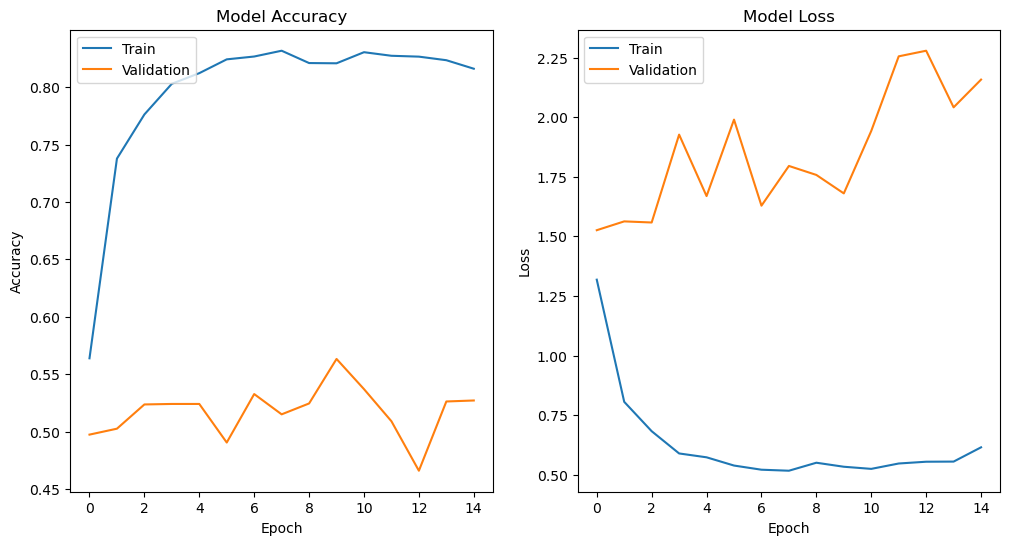

In [182]:
# Save the Model Plot
save_plot_model(file_output_path=file_output_path)

In [183]:
# Evaluate the Model
evaluate_model(test_generator=test_generator, file_output_path=file_output_path)

2024-04-30 07:52:55.002723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 53s 575ms/step - loss: 228.2455 - accuracy: 0.3852


***************************************************************************
+---+-------------------+--------------------+
|   |     Test Loss     |   Test Accuracy    |
+---+-------------------+--------------------+
| 0 | 228.2455291748047 | 0.3852233588695526 |
+---+-------------------+--------------------+
Model evaluation results saved in Model/Scenario1/ as model_evaluation_results.csv


2024-04-30 07:56:06.319537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 54s 599ms/step


/Users/rikza/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikza/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikza/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/



***************************************************************************
                              Confusion Matrix                             
[[170   0   0   6   0   3   0   6   2   0   0]
 [ 65 142   2  22   0  34   1  32   8   0   0]
 [119   0 109  14   5   3   0   2   0   1   0]
 [ 62   0   0 148   0  11   0  20   5   0   0]
 [ 47   0   2 116  69  65   1  38  16   0   0]
 [134   0   1  75   0 176   0  75   7   0   0]
 [ 44   3   1  57   1  13  34  24  30   0   0]
 [ 76   0   0   4   0   2   0 166   5   0   0]
 [ 46   3   0  57   2   4   0  11 105   0   0]
 [ 89   0   0   6   0   6   0  13   4   2   0]
 [ 76   3   1  69   1  58   8  46  26   0   0]]
***************************************************************************
                           Classification Report                           
                    precision    recall  f1-score   support

        basketball       0.18      0.91      0.30       187
            biking       0.94      0.46      0.62      

/Users/rikza/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikza/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rikza/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


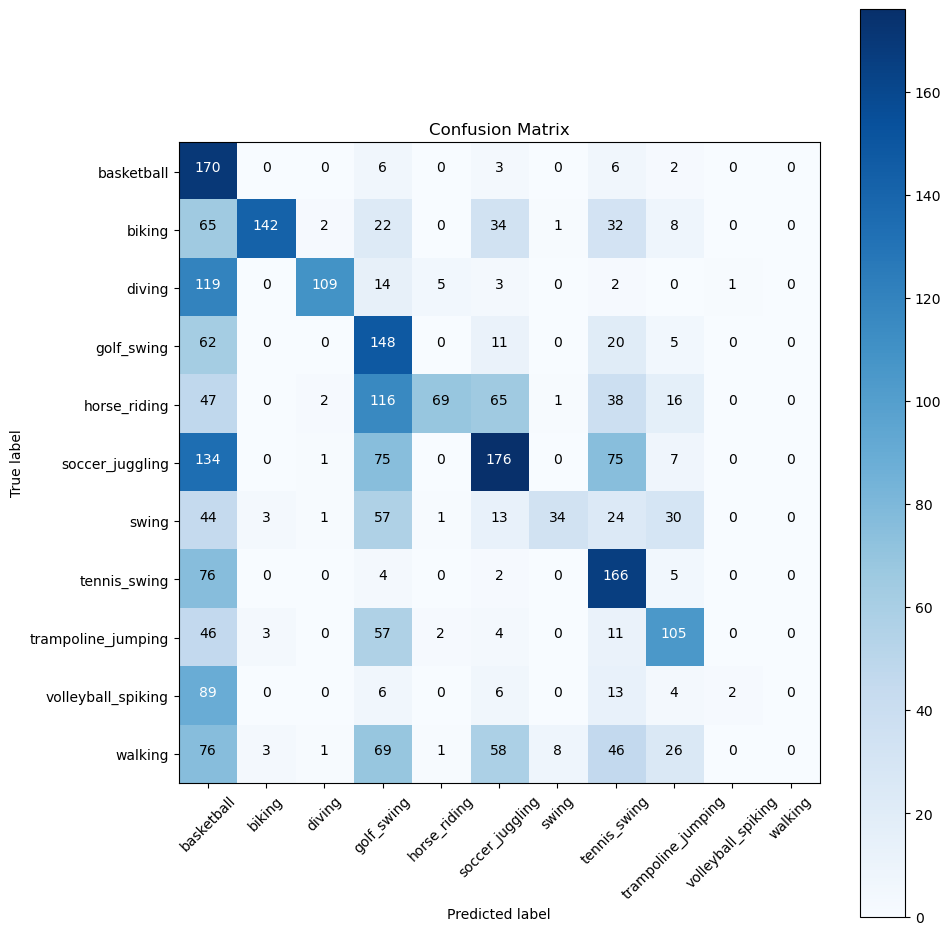

In [184]:
# Predict the Model
predict_model(test_generator=test_generator, file_output_path=file_output_path)

Loading: 100%|█████████▉| 2910/2911 [02:49<00:00, 17.20files/s]




***************************************************************************
                              Confusion Matrix                             
[[164   1   0   0   1   6   0   5   3   6   1]
 [  7 215   5   1   9  22   8   7  14   1  17]
 [  2   0 241   0   4   1   0   0   1   4   0]
 [  7   1   0 207   5   5   1   7   2   0  11]
 [  1   6   7   1 302  17   2   3   9   1   5]
 [ 29   5   0  12  20 355  10  27   4   1   5]
 [  0   4   4   2   6  11 158   2  14   1   5]
 [ 13   0   0   0   1   2   0 232   5   0   0]
 [  1   5   5   1   4   3   5   2 200   0   2]
 [  4   3   2   0   0   2   3   3   5  98   0]
 [  4  12   3   8  18  41  20   1   6   2 173]]
***************************************************************************
                           Classification Report                           
                    precision    recall  f1-score   support

        basketball       0.71      0.88      0.78       187
            biking       0.85      0.70      0.77      

ValueError: DataFrame constructor not properly called!

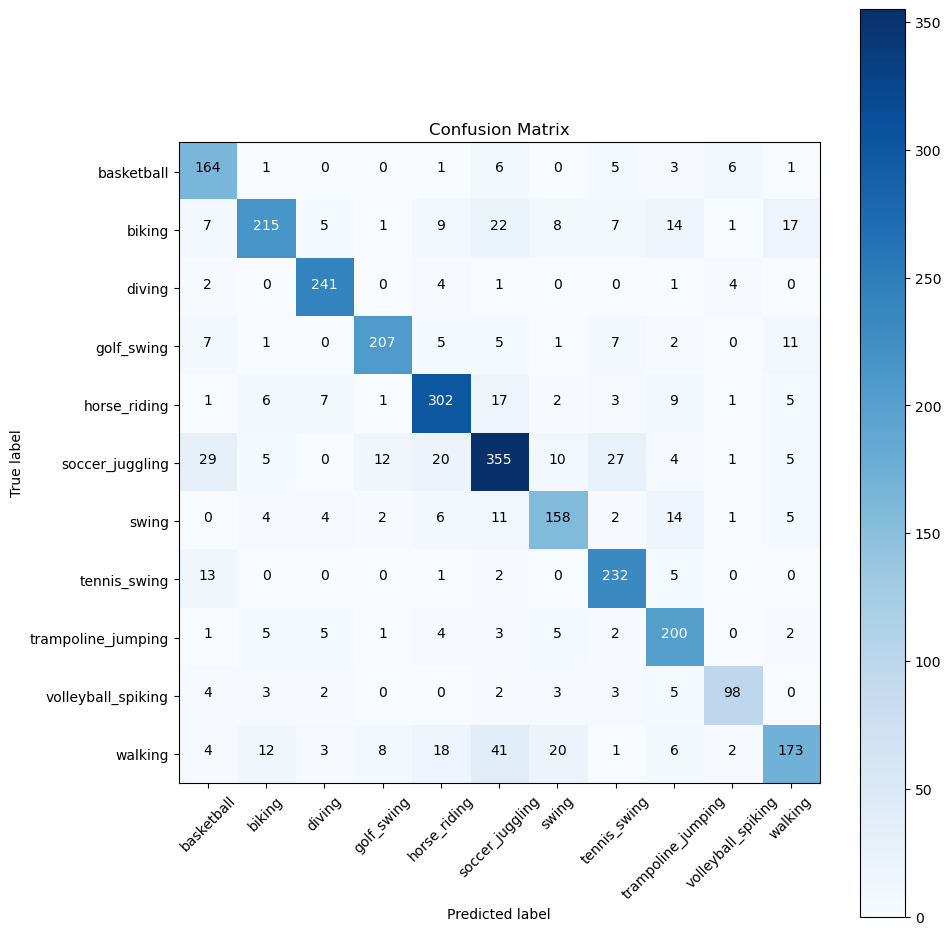

In [185]:
# Predict the Model1
predict_model1(test_generator=test_generator, file_output_path=file_output_path)